In [5]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import shutil
import itertools
import statannot
import math

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter
from scipy import signal

import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.backends.backend_pdf

%matplotlib inline

def flatten(t):
    return [item for sublist in t for item in sublist]

## load precomputed timeseries and stats

In [6]:
# define functions to load data
def load_betas(dataset, contrast, base_dir='/home/scotti/projects/3t_7t_sst_comparison'):
    contrast_beta = os.path.join(base_dir, f'derivatives/roi_glm/{dataset}',f'contrast_betas_{contrast}.tsv')
    contrast_beta = pd.read_csv(contrast_beta,sep='\t').rename(columns={pd.read_csv(contrast_beta,sep='\t').filter(regex='beta_.*').columns[0]: 'beta'})
    contrast_beta['dataset'] = dataset
    contrast_beta['contrast'] = contrast
    return contrast_beta

def load_stats(dataset, contrast, base_dir='/home/scotti/projects/3t_7t_sst_comparison'):
    contrast_stats = os.path.join(base_dir, f'derivatives/roi_glm/{dataset}',f'stat_{contrast}.tsv')
    contrast_stats = pd.read_csv(contrast_stats,sep='\t').rename(columns={'Unnamed: 0': 'ROI'})
    contrast_stats['dataset'] = dataset
    contrast_stats['contrast'] = contrast
    return contrast_stats

datasets = ['Leipzig_7T_GdH','Leipzig_7T_SM','NTNU_7T_SJSI','openfmri_3T','aron_3T']
contrasts = ['fsgo','fsss','ssgo']

In [3]:
# build dataframe of all roi glms
for idx, dataset in enumerate(datasets):
    for ids, contrast in enumerate(contrasts):
        if idx == 0 and ids == 0:
            all_betas = load_betas(dataset,contrast)
            all_stats = load_stats(dataset,contrast)
            
        else:
            all_betas = pd.concat([all_betas, load_betas(dataset,contrast)])
            all_stats = pd.concat([all_stats, load_stats(dataset,contrast)])

rois_ = ['IFG','SMA','M1','SN','STN','GPe','Tha']
rois_hemi = [item for items in [(x+'-l',x+'-r') for x in rois_] for item in items]

all_betas = all_betas[all_betas.ROI_nohemi.isin(rois_)]
all_stats = all_stats[all_stats.ROI.isin(rois_hemi)]
all_stats['hemisphere'] = [x[-1] for x in all_stats.ROI]
all_stats['ROI_nohemi'] = [x[:-2] for x in all_stats.ROI]

In [4]:
all_stats

,ROI,t,p,fdr_significant,p_corrected,significance,dataset,contrast,hemisphere,ROI_nohemi
0,IFG-l,3.436545,0.003388,True,0.012462,*,Leipzig_7T_GdH,fsgo,l,IFG
1,IFG-r,4.192794,0.000689,True,0.009643,**,Leipzig_7T_GdH,fsgo,r,IFG
2,SMA-l,0.975960,0.343610,False,0.370042,NaN,Leipzig_7T_GdH,fsgo,l,SMA
3,SMA-r,1.005012,0.329849,False,0.370042,NaN,Leipzig_7T_GdH,fsgo,r,SMA
4,M1-l,0.458846,0.652517,False,0.652517,NaN,Leipzig_7T_GdH,fsgo,l,M1
...,...,...,...,...,...,...,...,...,...,...
9,STN-r,1.337179,0.204092,False,0.408184,NaN,aron_3T,ssgo,r,STN
10,GPe-l,-0.568665,0.579275,False,0.675821,NaN,aron_3T,ssgo,l,GPe
11,GPe-r,1.199802,0.251626,False,0.411573,NaN,aron_3T,ssgo,r,GPe
12,Tha-l,2.960719,0.011042,True,0.038647,*,aron_3T,ssgo,l,Tha


# functions and plots

In [142]:
import numpy as np
import scipy.stats

# all this required for adding significance
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m+h # only need highest 

def mean_confidence_interval_lower(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m-h # only need highest 

def add_asteriks(ax_n, data, col_name, significance=0):
    l_count, r_count = 0, 0
    
    roi_data = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
    roi_data = roi_data.loc[roi_data.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
    roi_data_lower = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval_lower).reset_index().set_index('ROI_nohemi')
    roi_data_lower = roi_data_lower.loc[roi_data_lower.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
#     print(roi_data_lower)
#     for index, (y_val, region) in enumerate(zip(data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval), data.ROI.unique())):
    for index, (y_val, region, y_val_lower) in enumerate(zip(roi_data[col_name], data.ROI.unique(), roi_data_lower[col_name])):
#         print(significance)
#         print(region)
        if index%2 == 0:
            x_val = -0.26 + l_count
            l_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        else:
            x_val = 0.14 + r_count
            r_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        if y_val >= 0:
            ax[ax_n].text(x_val, y_val+0.005, significance[index])
        else:
            ax[ax_n].text(x_val, y_val_lower-0.017, significance[index])

In [379]:
import numpy as np
import scipy.stats

# all this required for adding significance
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m+h # only need highest 

def mean_confidence_interval_lower(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m-h # only need lowest 

def add_asteriks(ax_x, ax_y, hemi, data, stat_df):
    count=0
    
    # sort betas
    data = data[data.hemisphere==hemi] # select data only from hemi of interest
    roi_data = data.groupby(['ROI_nohemi','hemisphere','dataset'])['beta'].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi') # get mean CI
    roi_data = roi_data.loc[roi_data.index].drop_duplicates().reset_index()
    roi_data_lower = data.groupby(['ROI_nohemi','hemisphere','dataset'])['beta'].apply(mean_confidence_interval_lower).reset_index().set_index('ROI_nohemi') # get mean CI
    roi_data_lower = roi_data_lower.loc[roi_data_lower.index].drop_duplicates().reset_index()
    
    # sort stats
    stat_data = stat_df[stat_df.hemisphere==hemi][['significance','dataset','hemisphere','ROI_nohemi']]
    
    # merge for ease
    merged_df = roi_data.merge(stat_data, how = 'left', on = ['dataset', 'hemisphere','ROI_nohemi']).sort_values(['ROI_nohemi','dataset'])
    merged_df_lower = roi_data_lower.merge(stat_data, how = 'left', on = ['dataset', 'hemisphere','ROI_nohemi']).sort_values(['ROI_nohemi','dataset'])
#     print(merged_df)
    # precompute x axis coordinates for each asteriks
    x_vals = [value for key,value in enumerate(np.linspace(-0.35, 5.5, 35, endpoint=False),1) if key%6!=0] + list(np.linspace(5.65,6.48,5,endpoint=False))
    
    for index, (signif, y_val, region, y_val_lower) in enumerate(zip(merged_df['significance'], merged_df['beta'], merged_df.ROI_nohemi, merged_df_lower['beta'])):
        
        x_val = x_vals[index]
        if pd.isna(signif):
            continue

        if (aster:=len(signif)) == 2:
            x_val = x_val - 0.02
        elif aster == 3:
            x_val = x_val - 0.05
                
        if y_val >= 0:
            fg.axes[ax_x,ax_y].text(x_val, y_val+0.005, signif, fontsize=12)
        else:
            fg.axes[ax_x,ax_y].text(x_val, y_val_lower-0.017, signif, fontsize=12)


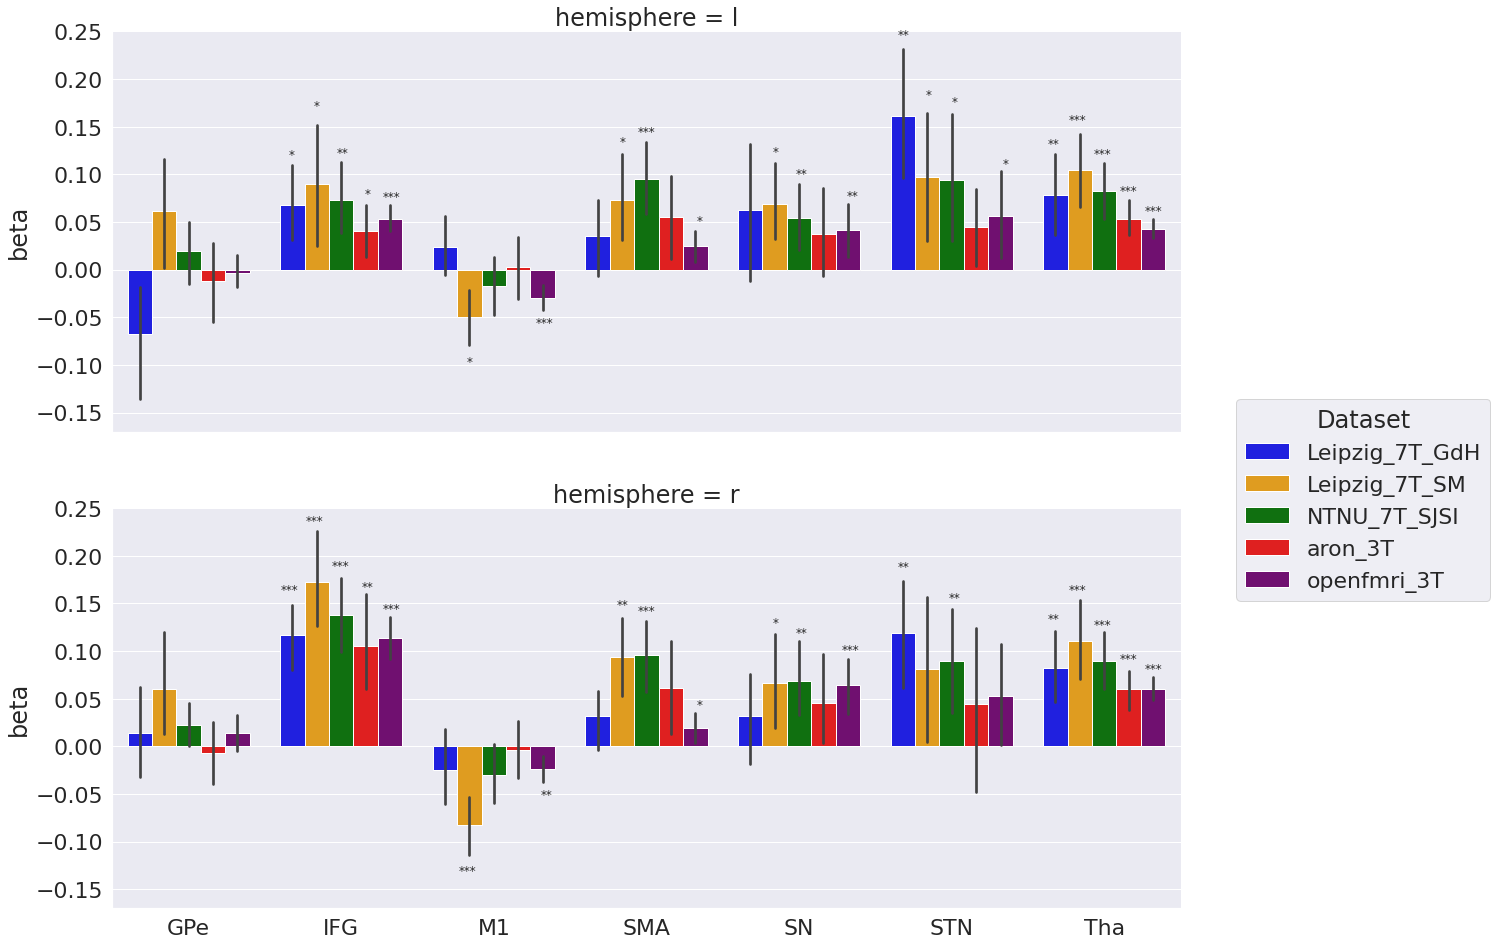

In [380]:
# fs > go
fsgo_betas = all_betas[all_betas.contrast=='fsgo'].sort_values(['ROI_nohemi','dataset'])
fsgo_stats = all_stats[all_stats.contrast=='fsgo'].sort_values(['ROI_nohemi','dataset'])
sns.set(font_scale=2)
fg = sns.catplot(x='ROI_nohemi', y='beta', hue='dataset', row='hemisphere', kind='bar',
            data=fsgo_betas,palette=("blue","orange","green","red","purple"),legend=False).set(xlabel=None,xlim=(-0.5,6.5),ylim=(-0.17,0.25))
plt.legend(loc='upper right', title='Dataset', bbox_to_anchor=(1.3, 1.3))

add_asteriks(0,0, 'l', fsgo_betas, fsgo_stats)
add_asteriks(1,0, 'r', fsgo_betas, fsgo_stats)
plt.gcf().set_size_inches(25,15)

In [372]:
fsss_betas

,subject,ROI,beta,hemisphere,ROI_nohemi,dataset,contrast
238,BI3T,GPe-l,0.093806,l,GPe,Leipzig_7T_GdH,fsss
239,FMFT,GPe-l,0.051372,l,GPe,Leipzig_7T_GdH,fsss
240,GAIT,GPe-l,-0.135273,l,GPe,Leipzig_7T_GdH,fsss
241,KCAT,GPe-l,-0.115162,l,GPe,Leipzig_7T_GdH,fsss
242,KP6T,GPe-l,-0.035053,l,GPe,Leipzig_7T_GdH,fsss
...,...,...,...,...,...,...,...
2711,11128,Tha-r,0.012582,r,Tha,openfmri_3T,fsss
2712,11131,Tha-r,-0.096293,r,Tha,openfmri_3T,fsss
2713,11143,Tha-r,-0.107836,r,Tha,openfmri_3T,fsss
2714,11149,Tha-r,0.024552,r,Tha,openfmri_3T,fsss


In [374]:
fsss_stats[fsss_stats.ROI_nohemi=='Tha']

,ROI,t,p,fdr_significant,p_corrected,significance,dataset,contrast,hemisphere,ROI_nohemi
26,Tha-l,2.255499,0.038458,False,0.088750,NaN,Leipzig_7T_GdH,fsss,l,Tha
27,Tha-r,2.276721,0.036893,False,0.088750,NaN,Leipzig_7T_GdH,fsss,r,Tha
26,Tha-l,3.474610,0.003718,True,0.012925,*,Leipzig_7T_SM,fsss,l,Tha
27,Tha-r,3.433876,0.004032,True,0.012925,*,Leipzig_7T_SM,fsss,r,Tha
26,Tha-l,4.338501,0.000150,True,0.000561,***,NTNU_7T_SJSI,fsss,l,Tha
27,Tha-r,3.982224,0.000401,True,0.001203,**,NTNU_7T_SJSI,fsss,r,Tha
26,Tha-l,1.247570,0.234195,False,0.468389,NaN,aron_3T,fsss,l,Tha
27,Tha-r,0.274651,0.787901,False,0.875445,NaN,aron_3T,fsss,r,Tha
26,Tha-l,1.549587,0.124531,False,0.355651,NaN,openfmri_3T,fsss,l,Tha
27,Tha-r,1.057399,0.292983,False,0.536956,NaN,openfmri_3T,fsss,r,Tha


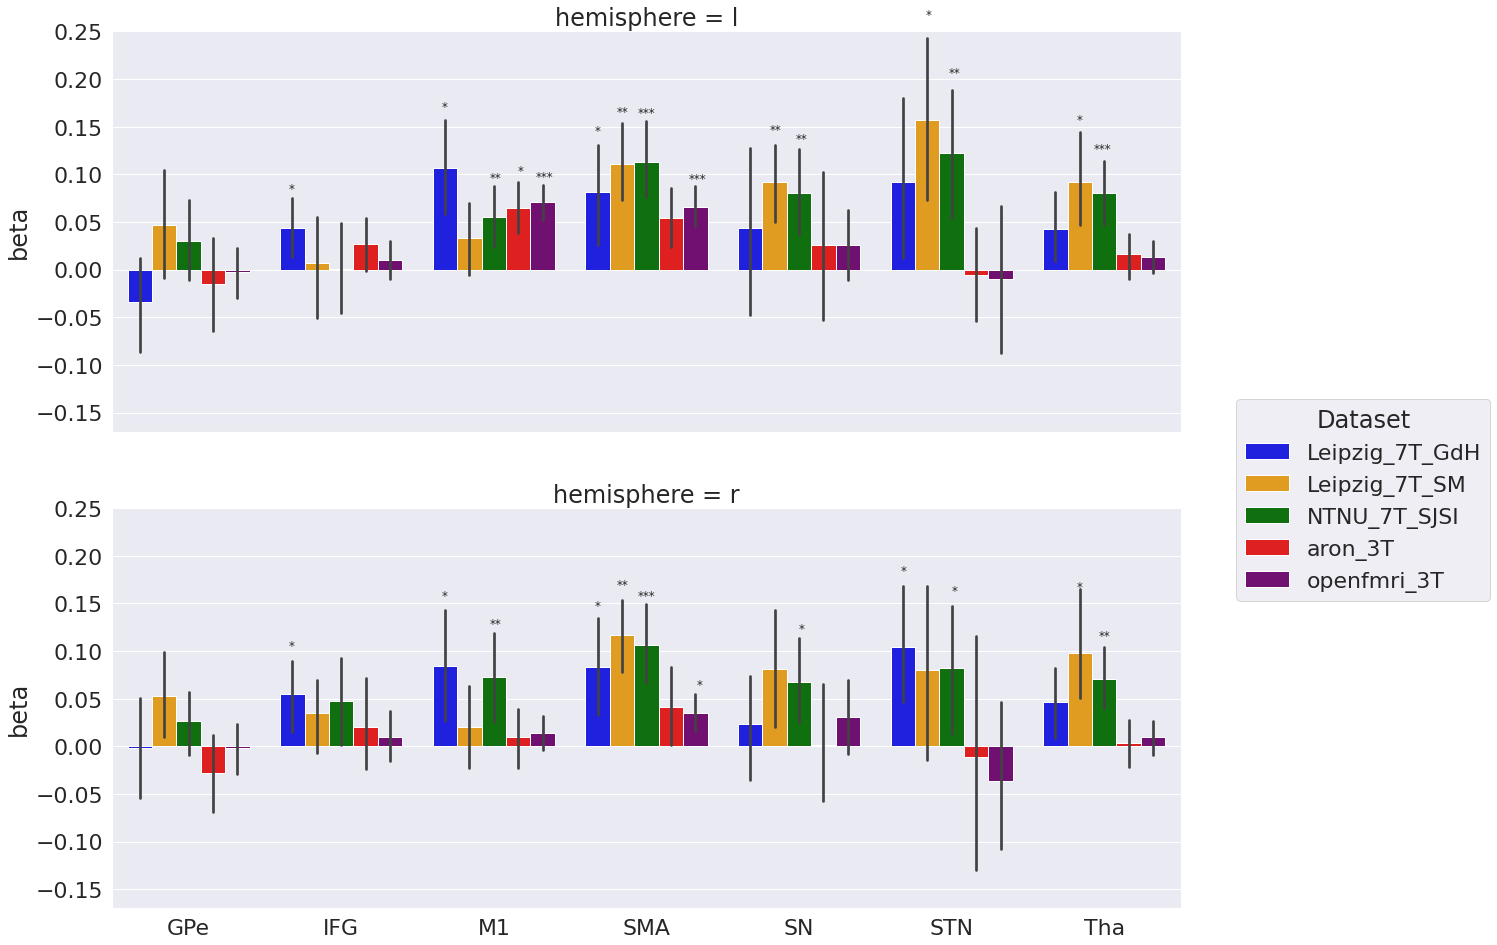

In [381]:
# fs > ss
fsss_betas = all_betas[all_betas.contrast=='fsss'].sort_values(['ROI_nohemi','dataset'])
fsss_stats = all_stats[all_stats.contrast=='fsss'].sort_values(['ROI_nohemi','dataset'])
sns.set(font_scale=2)
fg = sns.catplot(x='ROI_nohemi', y='beta', hue='dataset', row='hemisphere', kind='bar',
            data=fsss_betas,palette=("blue","orange","green","red","purple"),legend=False).set(xlabel=None,xlim=(-0.5,6.5),ylim=(-0.17,0.25))
plt.legend(loc='upper right', title='Dataset', bbox_to_anchor=(1.3, 1.3))

add_asteriks(0,0, 'l', fsss_betas, fsss_stats)
add_asteriks(1,0, 'r', fsss_betas, fsss_stats)
plt.gcf().set_size_inches(25,15)

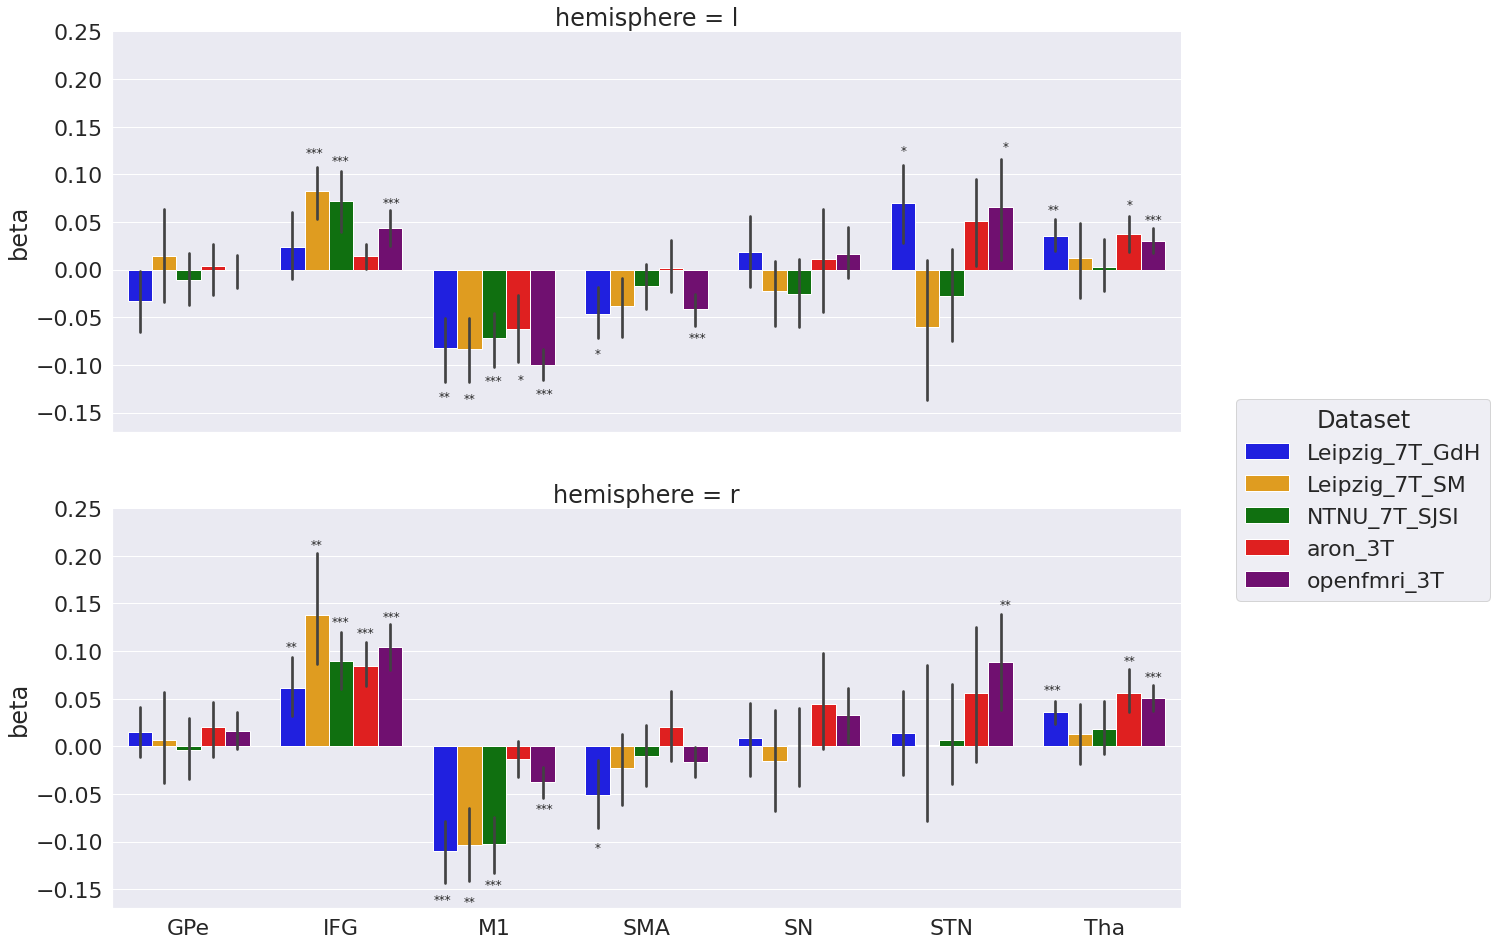

In [382]:
# ss > go
ssgo_betas = all_betas[all_betas.contrast=='ssgo'].sort_values(['ROI_nohemi','dataset'])
ssgo_stats = all_stats[all_stats.contrast=='ssgo'].sort_values(['ROI_nohemi','dataset'])
sns.set(font_scale=2)
fg = sns.catplot(x='ROI_nohemi', y='beta', hue='dataset', row='hemisphere', kind='bar',
            data=ssgo_betas,palette=("blue","orange","green","red","purple"),legend=False).set(xlabel=None,xlim=(-0.5,6.5),ylim=(-0.17,0.25))
plt.legend(loc='upper right', title='Dataset', bbox_to_anchor=(1.3, 1.3))

add_asteriks(0,0, 'l', ssgo_betas, ssgo_stats)
add_asteriks(1,0, 'r', ssgo_betas, ssgo_stats)
plt.gcf().set_size_inches(25,15)